In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import json
import pickle

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive
folder_path = '/content/drive/My Drive/tomato_combined_balanced_dataset'

# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# List the contents of the folder
print("Contents of the folder:")
for item in os.listdir(folder_path):
    print(item)

ValueError: mount failed

In [ ]:
!cp -r "/content/drive/My Drive/tomato_combined_balanced_dataset" /content/


In [ ]:
batch_size = 32
img_height = 224
img_width = 224
seed = 123
data_dir = "/content/tomato_combined_balanced_dataset"

In [ ]:
checkpoint_dir = '/content/drive/My Drive/convnext_224_checkpoints'  # Where to save checkpoints

# Create checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# ============== CHECK FOR PREVIOUS TRAINING ==============
checkpoint_info_path = os.path.join(checkpoint_dir, 'training_info.json')
history_path = os.path.join(checkpoint_dir, 'training_history.pkl')

previous_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

if os.path.exists(checkpoint_info_path):
    with open(checkpoint_info_path, 'r') as f:
        info = json.load(f)
        epoch = info['last_epoch']
        print(f"🔄 FOUND PREVIOUS TRAINING - Resuming from epoch {epoch}")
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            previous_history = pickle.load(f)
            print(f"📊 Last training metrics:")
            print(f"   Train Accuracy: {previous_history['accuracy'][-1]:.4f}")
            print(f"   Val Accuracy: {previous_history['val_accuracy'][-1]:.4f}")
else:
    print("🆕 Starting fresh training")


🆕 Starting fresh training


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 18010 files belonging to 9 classes.
Using 14408 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 18010 files belonging to 9 classes.
Using 3602 files for validation.


In [ ]:
num_classes = len(train_ds.class_names)
print("Classes:", train_ds.class_names)

Classes: ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Leaf_Mold', 'Mosaic_virus', 'Septoria_leaf_spot', 'Target_Spot', 'Yellow_Leaf_Curl_Virus']


In [ ]:
train_ds = train_ds.prefetch(2)
test_ds = val_ds.prefetch(2)

# ✅ mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Added vertical flip
    tf.keras.layers.RandomRotation(0.2),  # Increased from 0.1
    tf.keras.layers.RandomZoom(0.2),  # Increased from 0.1
    tf.keras.layers.RandomContrast(0.2),  # Increased from 0.1
    tf.keras.layers.RandomBrightness(0.2),  # NEW
    tf.keras.layers.RandomTranslation(0.1, 0.1),  # NEW - slight shifts
])

In [ ]:
base_model = tf.keras.applications.ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=(img_width, img_height, 3),
        pooling=None  # We'll add custom pooling
    )

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.trainable = True

# Optionally freeze first N layers if GPU is weak:
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
    inputs = tf.keras.Input(shape=(img_width, img_height, 3))

    # Data augmentation
    x = data_augmentation(inputs, training=True)

    # Preprocessing
    x = tf.keras.applications.convnext.preprocess_input(x)

    # Base model
    x = base_model(x, training=True)

    # Custom head with more capacity
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)  # Added layer
    x = tf.keras.layers.Dropout(0.4)(x)  # Increased dropout
    x = tf.keras.layers.BatchNormalization()(x)  # Added BN
    x = tf.keras.layers.Dense(256, activation='relu')(x)  # Added layer
    x = tf.keras.layers.Dropout(0.3)(x)

    # Output layer with label smoothing
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)


In [ ]:
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
class SaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_dir, previous_history):
        self.checkpoint_dir = checkpoint_dir
        self.history = previous_history

    def on_epoch_end(self, epoch, logs=None):
        actual_epoch = epoch

        # Update history
        for key in logs:
            if key in self.history:
                self.history[key].append(logs[key])

        # Save model
        model_path = os.path.join(self.checkpoint_dir, f'model_epoch_{actual_epoch+1}.keras')
        self.model.save(model_path)

        # Save just weights too (smaller file)
        weights_path = os.path.join(self.checkpoint_dir, f'weights_epoch_{actual_epoch+1}.weights.h5')

        self.model.save_weights(weights_path)
        info = {
            'last_epoch': actual_epoch,
            'val_accuracy': float(logs['val_accuracy']),
            'train_accuracy': float(logs['accuracy'])
        }
        with open(os.path.join(self.checkpoint_dir, 'training_info.json'), 'w') as f:
            json.dump(info, f)

        # Save history
        with open(os.path.join(self.checkpoint_dir, 'training_history.pkl'), 'wb') as f:
            pickle.dump(self.history, f)

        if actual_epoch > 3:
            old_model = os.path.join(self.checkpoint_dir, f'model_epoch_{actual_epoch-3}.keras')
            old_weights = os.path.join(self.checkpoint_dir, f'weights_epoch_{actual_epoch-3}.weights.h5')
            if os.path.exists(old_model):
                os.remove(old_model)
            if os.path.exists(old_weights):
                os.remove(old_weights)

        print(f"\n💾 Checkpoint saved: Epoch {actual_epoch+1} - "
              f"Train Acc: {logs['accuracy']:.4f}, Val Acc: {logs['val_accuracy']:.4f}")


In [ ]:
model = tf.keras.models.load_model(
    "/content/drive/My Drive/convnext_224_checkpoints/model_epoch_15.keras",  # set to False if you don’t need optimizer state
)

In [ ]:
history_continued = model.fit(
        train_ds,
        validation_data=test_ds,
        initial_epoch=15,
        epochs=30,
        callbacks=[SaveCallback(checkpoint_dir, previous_history)]
    )

Epoch 16/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9842 - loss: 0.0568
💾 Checkpoint saved: Epoch 15 - Train Acc: 0.9819, Val Acc: 0.9845
451/451 ━━━━━━━━━━━━━━━━━━━━ 348s 609ms/step - accuracy: 0.9842 - loss: 0.0569 - val_accuracy: 0.9845 - val_loss: 0.0654
Epoch 17/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9824 - loss: 0.0623
💾 Checkpoint saved: Epoch 16 - Train Acc: 0.9816, Val Acc: 0.9758
451/451 ━━━━━━━━━━━━━━━━━━━━ 203s 345ms/step - accuracy: 0.9824 - loss: 0.0623 - val_accuracy: 0.9758 - val_loss: 0.1479
Epoch 18/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9870 - loss: 0.0510
💾 Checkpoint saved: Epoch 17 - Train Acc: 0.9836, Val Acc: 0.9720
451/451 ━━━━━━━━━━━━━━━━━━━━ 196s 332ms/step - accuracy: 0.9870 - loss: 0.0510 - val_accuracy: 0.9720 - val_loss: 0.1367
Epoch 19/30
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9824 - loss: 0.0603
💾 Checkpoint saved: Epoch 18 - Train Acc: 0.9820, Val Acc: 0.9661
451/451 ━━━━━━━━━

In [ ]:
history_continued = model.fit(
        train_ds,
        validation_data=test_ds,
        initial_epoch=30,
        epochs=40,
        callbacks=[SaveCallback(checkpoint_dir, previous_history)]
    )

Epoch 31/40
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9884 - loss: 0.0399
💾 Checkpoint saved: Epoch 30 - Train Acc: 0.9869, Val Acc: 0.8681
451/451 ━━━━━━━━━━━━━━━━━━━━ 163s 361ms/step - accuracy: 0.9884 - loss: 0.0399 - val_accuracy: 0.8681 - val_loss: 0.6984
Epoch 32/40
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9882 - loss: 0.0446
💾 Checkpoint saved: Epoch 31 - Train Acc: 0.9894, Val Acc: 0.9639
451/451 ━━━━━━━━━━━━━━━━━━━━ 196s 348ms/step - accuracy: 0.9882 - loss: 0.0446 - val_accuracy: 0.9639 - val_loss: 0.1640
Epoch 33/40
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9910 - loss: 0.0312
💾 Checkpoint saved: Epoch 32 - Train Acc: 0.9905, Val Acc: 0.9703
451/451 ━━━━━━━━━━━━━━━━━━━━ 158s 350ms/step - accuracy: 0.9910 - loss: 0.0312 - val_accuracy: 0.9703 - val_loss: 0.1429
Epoch 34/40
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9921 - loss: 0.0316
💾 Checkpoint saved: Epoch 33 - Train Acc: 0.9919, Val Acc: 0.9797
451/451 ━━━━━━━━━

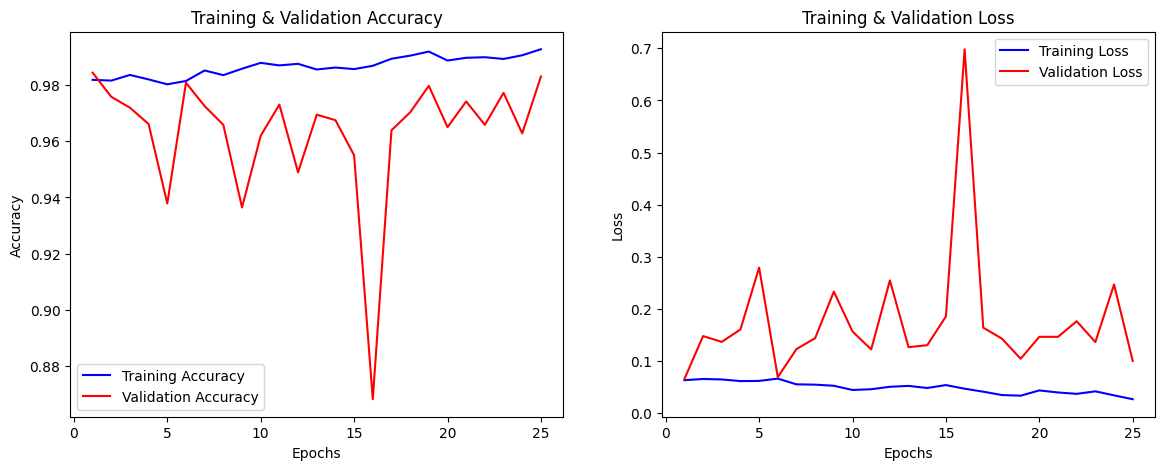

In [ ]:
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import os

history_path = "/content/drive/My Drive/convnext_224_checkpoints/training_history.pkl"


# ---- Load history ----
with open(history_path, "rb") as f:
    history = pickle.load(f)

# ---- Plot training vs validation accuracy and loss ----
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b-", label="Training Accuracy")
plt.plot(epochs, val_acc, "r-", label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b-", label="Training Loss")
plt.plot(epochs, val_loss, "r-", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


# Preventing Overfitting

In [ ]:
# Data loading
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

num_classes = len(train_ds.class_names)

# Optimize without cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)  # No cache()
test_ds = val_ds.prefetch(AUTOTUNE)  # No cache()

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

train_ds = train_ds.prefetch(2)
test_ds = test_ds.prefetch(2)

Found 18010 files belonging to 9 classes.
Using 14408 files for training.
Found 18010 files belonging to 9 classes.
Using 3602 files for validation.


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

In [ ]:
base_model = tf.keras.applications.ConvNeXtTiny(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_height, 3),
    pooling=None
)

# CHANGE: Start with frozen base
base_model.trainable = False  # Will unfreeze later

inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs, training=True)
x = tf.keras.applications.convnext.preprocess_input(x)
x = base_model(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # CHANGE: Increased from 0.4
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)  # CHANGE: Increased from 0.3
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", dtype='float32')(x)
 # Added dtype for mixed precision

model = tf.keras.Model(inputs, outputs)

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=1e-4),  # Reduced LR
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False
    ),
    metrics=["accuracy"]
)

In [ ]:
callbacks = [
    SaveCallback(checkpoint_dir, previous_history),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

In [ ]:
print("Stage 1: Training with frozen base...")
history1 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=callbacks
)

Stage 1: Training with frozen base...
Epoch 1/15
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.3731 - loss: 1.8327
💾 Checkpoint saved: Epoch 1 - Train Acc: 0.5124, Val Acc: 0.7315
451/451 ━━━━━━━━━━━━━━━━━━━━ 245s 417ms/step - accuracy: 0.3734 - loss: 1.8318 - val_accuracy: 0.7315 - val_loss: 0.7673 - learning_rate: 5.0000e-04
Epoch 2/15
450/451 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6894 - loss: 0.9217
💾 Checkpoint saved: Epoch 2 - Train Acc: 0.7093, Val Acc: 0.8148
451/451 ━━━━━━━━━━━━━━━━━━━━ 110s 182ms/step - accuracy: 0.6895 - loss: 0.9215 - val_accuracy: 0.8148 - val_loss: 0.5364 - learning_rate: 5.0000e-04
Epoch 3/15
450/451 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7598 - loss: 0.7145
💾 Checkpoint saved: Epoch 3 - Train Acc: 0.7667, Val Acc: 0.8365
451/451 ━━━━━━━━━━━━━━━━━━━━ 148s 196ms/step - accuracy: 0.7599 - loss: 0.7144 - val_accuracy: 0.8365 - val_loss: 0.4669 - learning_rate: 5.0000e-04
Epoch 4/15
450/451 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - 

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=1e-5,  # Much lower for fine-tuning
        weight_decay=1e-4
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    initial_epoch=15,
    epochs=35,
    callbacks=callbacks
)

Epoch 16/35
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8723 - loss: 0.3682
💾 Checkpoint saved: Epoch 16 - Train Acc: 0.8792, Val Acc: 0.9159
451/451 ━━━━━━━━━━━━━━━━━━━━ 308s 559ms/step - accuracy: 0.8724 - loss: 0.3682 - val_accuracy: 0.9159 - val_loss: 0.2379 - learning_rate: 1.0000e-05
Epoch 17/35
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8854 - loss: 0.3354
💾 Checkpoint saved: Epoch 17 - Train Acc: 0.8903, Val Acc: 0.9267
451/451 ━━━━━━━━━━━━━━━━━━━━ 190s 353ms/step - accuracy: 0.8855 - loss: 0.3354 - val_accuracy: 0.9267 - val_loss: 0.2089 - learning_rate: 1.0000e-05
Epoch 18/35
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9005 - loss: 0.2996
💾 Checkpoint saved: Epoch 18 - Train Acc: 0.8975, Val Acc: 0.9300
451/451 ━━━━━━━━━━━━━━━━━━━━ 162s 359ms/step - accuracy: 0.9005 - loss: 0.2996 - val_accuracy: 0.9300 - val_loss: 0.2023 - learning_rate: 1.0000e-05
Epoch 19/35
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9102 - loss: 0.2710

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    initial_epoch=35,
    epochs=50,
    callbacks=callbacks
)

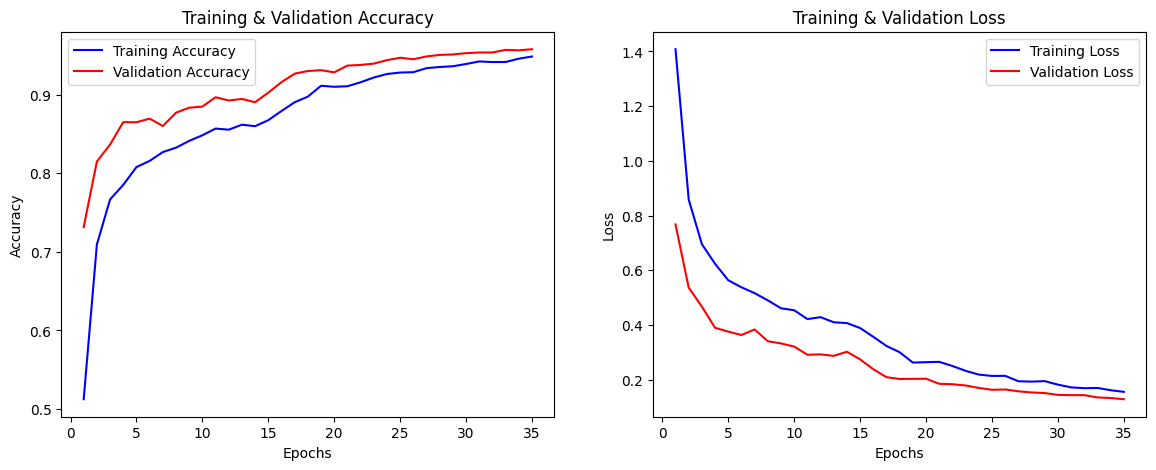

In [ ]:
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import os

history_path = "/content/drive/My Drive/convnext_224_checkpoints/training_history.pkl"


# ---- Load history ----
with open(history_path, "rb") as f:
    history = pickle.load(f)

# ---- Plot training vs validation accuracy and loss ----
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b-", label="Training Accuracy")
plt.plot(epochs, val_acc, "r-", label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b-", label="Training Loss")
plt.plot(epochs, val_loss, "r-", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()